# Scripts for kmeans and spectral clustering

Math 313, Guangliang Chen, 9/25/2023

## kmeans clustering

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import sklearn
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

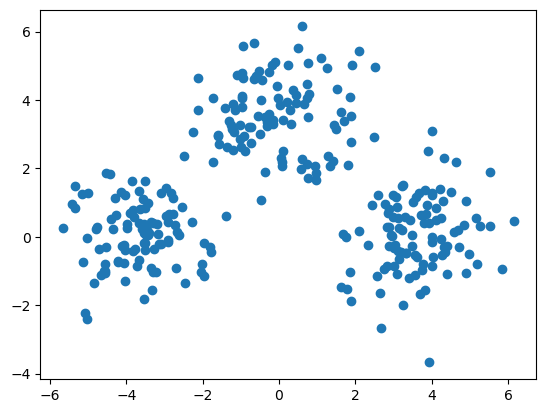

In [3]:
# create or load data

dataset = 'threegaussians'
#dataset = 'twomoons'
#dataset = 'threecircles'

match str.lower(dataset):
    
    case 'threegaussians':
        X1 = np.random.randn(100,2) + [-3.5,0]
        X2 = np.random.randn(100,2) + [3.5,0]
        X3 = np.random.randn(100,2) + [0,3.5]
        X = np.concatenate((X1, X2, X3), axis=0)
        truelabels = np.repeat([0,1,2], 100)
        k = 3
            
    case 'twomoons':
        mat_data = scipy.io.loadmat('twomoons.mat')
        X = mat_data['X']
        truelabels = mat_data['labels']  # 1/-1 labels
        truelabels = (truelabels+1) // 2;   # convert to 0/1
        k = 2
        
    case 'threecircles':
        mat_data = scipy.io.loadmat('threecircles.mat')
        X = mat_data['X']
        truelabels = mat_data['labels']    # 1/2/3 labels
        truelabels = truelabels - 1        # change to 0/1/2
        k = 3
        
    case _:
        print("Dataset does not exist")
        
n = X.shape[0]  # number of data points

plt.scatter(x=X[:,0], y=X[:,1])   # plot the data

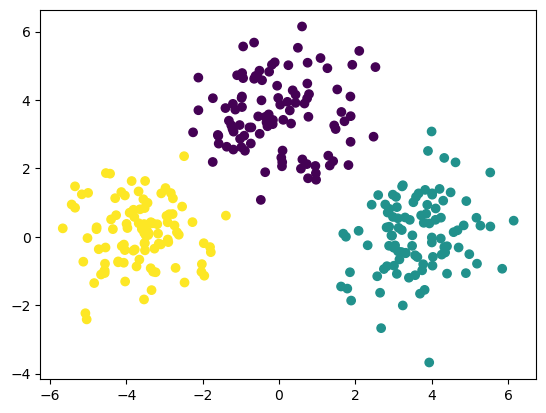

In [4]:
# apply kmeans with randomly selected seed points
kmeans = KMeans(n_clusters=k, init='random', n_init=10).fit(X)

plt.scatter(x=X[:,0], y=X[:,1], c=kmeans.labels_)

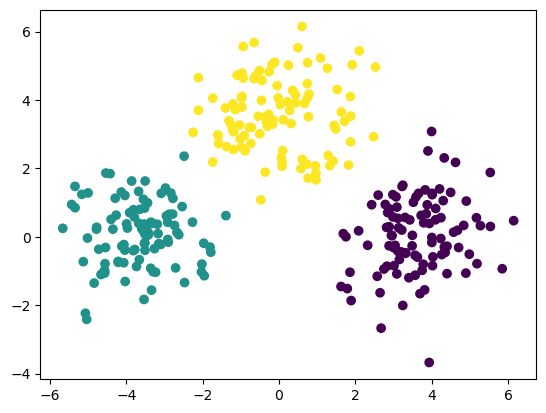

In [5]:
# kmeans++
kmeans = KMeans(n_clusters=k, n_init="auto").fit(X)

plt.scatter(x=X[:,0], y=X[:,1], c=kmeans.labels_)

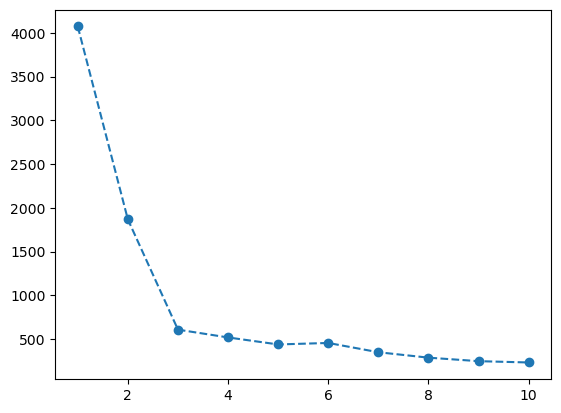

In [6]:
# selecting the number of clusters

scatter = np.array(range(10))
for i in range(10):
    kmeans = KMeans(n_clusters=i+1, n_init="auto").fit(X)
    scatter[i] = kmeans.inertia_
    
plt.plot(np.array(range(10))+1, scatter, marker='o', linestyle="--")

## spectral clustering

In [7]:
from sklearn.neighbors import NearestNeighbors

r = 6
nbrs = NearestNeighbors(n_neighbors=r, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
sigma = np.mean(distances[:,r-1])
sigma

0.535418749005299

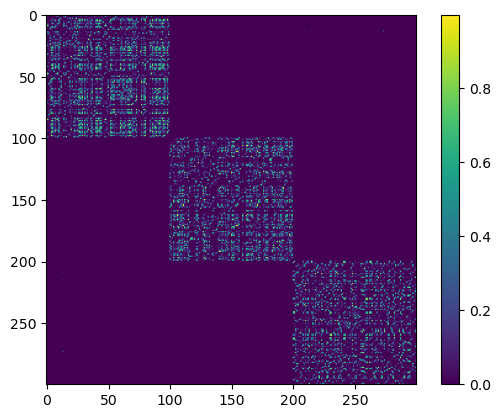

In [8]:
# direct implementation of spectral clustering from scratch

sigma = 0.5; # scale parameter

dists = sklearn.metrics.pairwise_distances(X)  # compute pairwise distances
dists_sq = dists ** 2  # squared distances
dists_sq_scaled = dists_sq / (2*sigma**2);  # scale by sigma

W = np.exp(-dists_sq_scaled)  # taking exponential to get similarities
np.fill_diagonal(W, 0)  # set diagonals of W to zero

plt.imshow(W)
plt.colorbar()

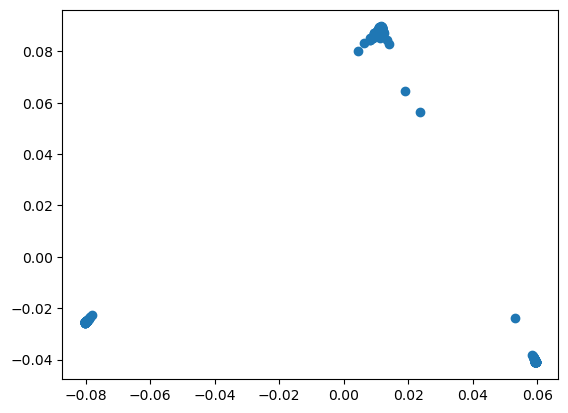

In [9]:
P = normalize(W, axis=1, norm='l1')           # scale each row by row sum 

eigvals, eigvecs = np.linalg.eig(P)           # compute eigenvalues and eigenvectors of P
#eigvecs[:,0] # v1 is a constant vector

idx = eigvals.argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

if k == 2:
    Y = np.array([eigvecs[:,1], np.zeros(n)]) # if only 2 clusters, then append v2 with a zero vector to make Y 2D
    Y = Y.transpose()
elif k>2:
    Y = eigvecs[:,1:k]                        # more than 2 clusters, use v_2 through v_k

plt.scatter(x=Y[:,0], y=Y[:,1])               # plot the embedding of the data by spectral clustering

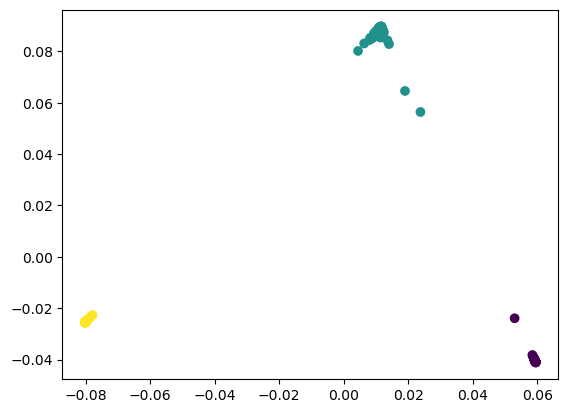

In [10]:
kmeans = KMeans(n_clusters=k, n_init="auto").fit(Y)   

plt.scatter(x=Y[:,0], y=Y[:,1], c=kmeans.labels_)

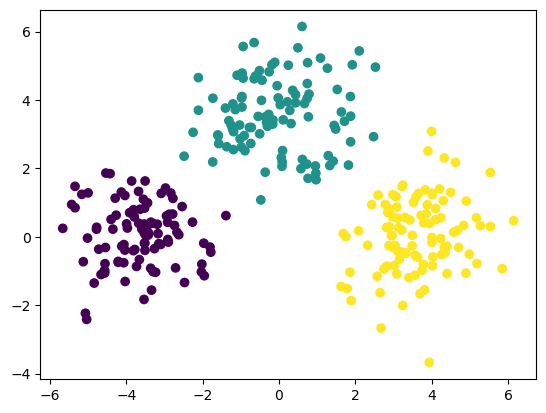

In [11]:
plt.scatter(x=X[:,0], y=X[:,1], c=kmeans.labels_)

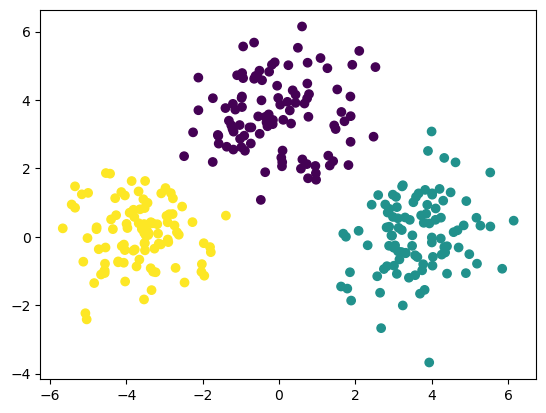

In [12]:
# There is a function in Python you can use instead for spectral clustering 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

from sklearn.cluster import SpectralClustering

speclust = SpectralClustering(n_clusters=k, gamma = 1/(2*sigma**2)).fit(X)

plt.scatter(x=X[:,0], y=X[:,1], c=speclust.labels_)

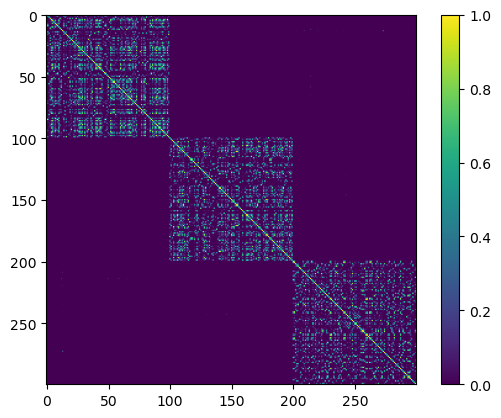

In [13]:
plt.imshow(speclust.affinity_matrix_)
plt.colorbar()

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(truelabels, speclust.labels_) 

array([[  1,   0,  99],
       [  0, 100,   0],
       [100,   0,   0]])

In [16]:
speclust.labels_.shape

(300,)

In [17]:
truelabels.shape

(300,)